## Calling the file and converting it to data(array)

In [15]:
from jupyterthemes import jtplot
jtplot.style()

In [16]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
from scipy import interpolate
from astropy.table import Table
t = Table.read('/Users/tusharkantidas/NIUS/Temp/015.xml')
#print(t)
from astropy.io.votable import parse_single_table
table = parse_single_table('/Users/tusharkantidas/NIUS/Temp/015.xml')
#print(table)
#%matplotlib notebook
data = table.array

## Giving some initial constants for the program

In [17]:
lambda_o = 5000  # # # This is the confusion. What are we supposed to take this lambda not.
inclination = (np.pi)/6         # in radian
c = sci.constants.c # speed of light
G = sci.constants.G        #gravitational constant
sigma = sci.constants.sigma     #stephen boltzmann constant

## Determining the truncation radius and plot of radius vs temp

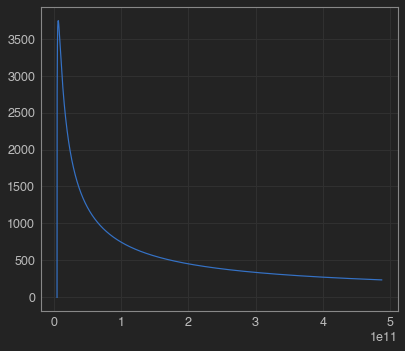

In [18]:
# R_in # inner truncation radius
# Refering Bovier paper
B_s = 1000 * (10**(-4))# in TESLA SI Unit
M_s = 0.6 * 1.9891 * (10**30) # twice of our sun in kg
M_dot_s = 3.8 * 10**(-5) * 1.9891 * (10**30) # accretion rate in units of mass of sun ##per year
M_dot_s = (3.8 * 10**(-5) * 1.9891 * (10**30))/(60*60*24*365.25) # in kg per sec
R_s = 2 * 696340 * 1000 # in metres

R_in_trunc = ((B_s)**(4/7) * (R_s)**(12/7))/((M_dot_s)**(2/7) * (2*G*M_s)**(1/7)) # in SI units
R_in_trunc = 3.5 * R_s
R_in_trunc
# Problem is reading the values in formula for R_trucation


# dont know why are the values so large????
radius = np.linspace(R_in_trunc, 100 * R_in_trunc, 10000)
tempp = ((3 * G * M_s * M_dot_s) / (8 * np.pi * sigma * ((radius) ** 3)) * (1 - ((R_in_trunc / radius) ** (1 / 2))))**0.25
plt.plot(radius,tempp)

## Trimming the radius and temp around temp of interest and determining R

In [19]:
# here we define a window of 100K where we want to find the average value of radius for a given input of temperature
radius_vs_temp = (radius,tempp)  # define an array of rad vs temp
t = int(input('Enter the value of temp: '))  # input the temp of interest
trimmed_temp = np.extract(tempp > t - 50,tempp)
trimmed_temp = np.extract(trimmed_temp < t + 50, trimmed_temp)
trimmed_temp # Window of interest in terms of temp
trimmed_radius = np.extract(tempp > t - 50, radius)
trimmed_radius = np.extract(trimmed_temp < t + 50, trimmed_radius)
trimmed_radius  # Window of interest in terms of radius
print('Total no of data points in temp range {} +/- 50 is {}'.format(t,len(trimmed_radius)))
print('Average value of radius that can be taken: {}'.format(sum(trimmed_radius)/len(trimmed_radius)))
R = sum(trimmed_radius)/len(trimmed_radius) # radius of accretion disk at that temperature

Enter the value of temp: 1500
Total no of data points in temp range 1500 +/- 50 is 76
Average value of radius that can be taken: 6732435742.574257


In [20]:
print(R)# Radius
v_kep = (G*M_s/R)**0.5
print('v keplerian: ',v_kep)
np.sin(inclination)/(c) * v_kep
lambda_max = (lambda_o * np.sin(inclination))/(c) * v_kep
print('Lamba Max: ',lambda_max)
print('kernel width: {}'.format(lambda_max*2))

6732435742.574257
v keplerian:  108772.89493608935
Lamba Max:  0.9070683070360073
kernel width: 1.8141366140720145


## Trimming the wavelength and flux from 3000-50000

In [21]:
#finding initial sampling rate of the data
trimmed_data = np.extract(data['WAVELENGTH']>3000,data)
trimmed_data = np.extract(trimmed_data['WAVELENGTH']<50000,trimmed_data)
print(trimmed_data[0],trimmed_data[-1])
# Sampling rate at Lambda not 
trim_dta = np.extract(trimmed_data['WAVELENGTH']>(lambda_o-lambda_max),trimmed_data)
trim_dta = np.extract(trim_dta['WAVELENGTH']<(lambda_o+lambda_max),trim_dta)
trim_dta
print('Sampling rate at lambda_0: ',len(trim_dta))
#sampling at initial lambda
trim_dta_2 = np.extract(trimmed_data['WAVELENGTH']<(trimmed_data['WAVELENGTH'][0]+(2*lambda_max)),trimmed_data)
#print(trim_dta_2)
print(len(trim_dta_2))
print('Initial Sampling rate at lambda_i: ',len(trim_dta_2))
#sampling at final lambda
trim_dta_3 = np.extract(trimmed_data['WAVELENGTH']>(trimmed_data['WAVELENGTH'][-1]-(2*lambda_max)),trimmed_data)
trim_dta_3
print('Initial Sampling rate at lambda_f: ',len(trim_dta_3))

(3000.030029296875, 0.005119080189615488) (49999.80078125, 1492.6199951171875)
Sampling rate at lambda_0:  36
37
Initial Sampling rate at lambda_i:  37
Initial Sampling rate at lambda_f:  10


## Determining the difference between subsequent data points 

In [22]:
x_dash = trimmed_data['WAVELENGTH']
y_dash = trimmed_data['FLUX']
diff_in_wave = [0]
for i in range(len(x_dash)-1):
    diff_dash = x_dash[i+1]-x_dash[i]
    diff_in_wave.append(diff_dash)
#print(diff_wavelength_dash)
print(len(diff_in_wave))
#plt.plot(x_dash,np.log10(diff_wavelength_dash))
diff_in_wave[-1]
#here I see that the difference is not increasing linearly.
# We from ourselves define a new linspace such that the difference is linearly increasing
len(y_dash)
#diff_in_wave

420050


420050

# Define a new linespace and calc the cumm sum

## Here we have to tune 2nd parameter in line 3 so that cf[-1] is close to 50000 but less


In [23]:
#define a new linspace
len(diff_in_wave)
new_difference = np.linspace(diff_in_wave[0],0.22378,420051) # the final value how to approach in proper method
#plt.plot(x,wave_dash)
#wave_dash
print(new_difference)
cumsumm = [0]

for i in range(len(new_difference)):
    xx = new_difference[i] + cumsumm[-1]
    cumsumm.append(xx)
#cf = np.cumsum(new_difference)
#print(cumsumm)
'''x_new = [3000]
for i in range(len(cf)-1):
    new_ele =  cf[i] - x_new[-1]
    x_new.append(new_ele)
len(x_new)
x_new[-1]'''
#new_x = np.linspace(3000,50000,420051)
#plt.plot(new_x,cf)
cf = []
for i in range(len(diff_in_wave)):
    cs = 3000 + cumsumm[i]
    cf.append(cs)
diff_in_wave[-3]
cf[-1]


[0.00000000e+00 5.32746102e-07 1.06549220e-06 ... 2.23778935e-01
 2.23779467e-01 2.23780000e-01]


49999.05883053245

# Defining the kernel and normalise

In [24]:
#NEW KERNEL #taking lambda not  == lambda not
print(R)# Radius

#Writing the kernel
#x_inter
para_1 = lambda_o-lambda_max
para_2 = lambda_o+lambda_max
para_3 = len(trim_dta_2)
print(para_1, para_2, para_3)
ax = np.linspace(para_1,para_2,para_3,False)
y_ker = (1-((ax-lambda_o)/lambda_max)**2)**(-0.5)
y_ker = np.ma.masked_invalid(y_ker)
y_ker = np.ma.filled(y_ker, 0)
ax=np.delete(ax,0)
y_ker=np.delete(y_ker,0)
#plt.plot(ax,y_ker,)
# y_ker.count()
w = np.count_nonzero(y_ker)
#print(y_ker[0])

# normalise the kernel
#Area calc
'''new_x
dx = (ax[-1]-ax[0])/len(ax)
print(dx)
elemental_area = []
for r in range(len(ax)):
    are = ax[r]*dx
    elemental_area.append(are)
total_area = sum(elemental_area)
total_area'''
final_kernel = y_ker/np.sum(y_ker)
final_kernel

6732435742.574257
4999.092931692964 5000.907068307036 37


array([0.06264475, 0.04492488, 0.03721653, 0.03271515, 0.02971501,
       0.02756001, 0.02593739, 0.02467697, 0.02367749, 0.02287463,
       0.02222557, 0.02170078, 0.02127936, 0.02094633, 0.02069088,
       0.02050531, 0.02038433, 0.02032464, 0.02032464, 0.02038433,
       0.02050531, 0.02069088, 0.02094633, 0.02127936, 0.02170078,
       0.02222557, 0.02287463, 0.02367749, 0.02467697, 0.02593739,
       0.02756001, 0.02971501, 0.03271515, 0.03721653, 0.04492488,
       0.06264475])

# Interpolate the data and determine new_y as function of cf

420050
x_dash  [3000.030029296875 3000.080078125 3000.1298828125 ... 49999.3984375
 49999.6015625 49999.80078125]
cf 3000 49999.05883053245
336
420049
420050


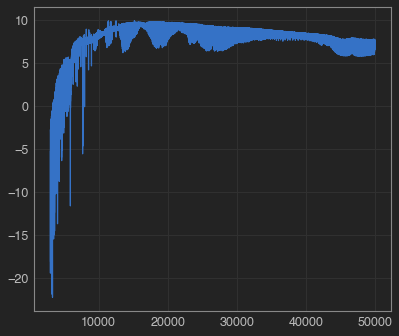

In [25]:
# interpolate with a fixed function throughout
y_dash
f = interpolate.interp1d(x_dash,y_dash)
#x_after_inter = np.linspace(3000.1,49999.00,420051)
print(len(cf))
#cf.remove(3000)
print('x_dash ',x_dash)
print('cf' ,cf[0],cf[-1])
reqq = x_dash[0]
diff_array = np.absolute(cf - reqq)
index_min = diff_array.argmin()
print(index_min)
index_max = diff_array.argmax()
print(index_max)
print(len(x_dash))
new_y = f(cf[index_min+1:])
plt.plot(cf[index_min+1:index_max+1],np.log(new_y))
#plt.plot()

# Convolution and plotting

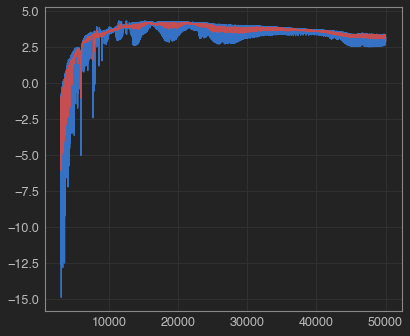

In [26]:
convolved_curve = np.convolve(new_y, final_kernel, mode='same')
plt.plot(x_dash,np.log10(y_dash),'b',cf[index_min:index_max],np.log10(convolved_curve),'r')